In [1]:
from pyspark.sql import SparkSession
from os import environ

In [2]:
# environ.get('SPARK_JDBC')

In [2]:
# SparkSession.builder.config('spark.driver.extraClassPath',environ.get('SPARK_JDBC')).getOrCreate()
spark = SparkSession.builder.appName('box_score_analysis').getOrCreate()

KeyboardInterrupt: 

In [3]:
query = 'select players.name as name, A.*  from '
query += '(select teams.name as team, box_scores.* from box_scores inner join teams on ' 
query += 'team_id = id) ' 
query += 'A inner join players on player_id = id'


df = spark.read.format('jdbc').option('url','jdbc:mysql://localhost:3306/nba').\
    option('user',environ.get('USER')).option('password',environ.get('PSWD')).\
    option('query',query).load()

In [5]:
df = df.drop('player_id','team_id')

Select scoring stats from the original df

In [4]:
scoring_stats = ['pts','fgm','fga','pm3','pa3','ftm','fta','ast']
identifiers = ['name','team', 'game_day']
label = ['result']
scoring_df = df[identifiers+label+scoring_stats]

Compute some derived scoring stats

In [5]:
scoring_df = scoring_df.withColumn('ft%', scoring_df.ftm/scoring_df.fta)
scoring_df = scoring_df.withColumn('fg%', scoring_df.fgm/scoring_df.fga)
scoring_df = scoring_df.withColumn('3p%', scoring_df.pm3/scoring_df.pa3)
scoring_df = scoring_df.withColumn('2p%', 
            (scoring_df.fgm - scoring_df.pm3)/(scoring_df.fga -scoring_df.pa3))
scoring_df = scoring_df.withColumn('eFG%', (scoring_df.fgm + 0.5*scoring_df.pm3)/scoring_df.fga)

In [6]:
from pyspark.ml.feature import StringIndexer

In [7]:
result_labler = StringIndexer(inputCol='result',outputCol='win',
                stringOrderType='alphabetAsc').fit(scoring_df)

In [8]:
scoring_df = result_labler.transform(scoring_df)

In [10]:
scoring_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- team: string (nullable = true)
 |-- game_day: date (nullable = true)
 |-- result: string (nullable = true)
 |-- pts: integer (nullable = true)
 |-- fgm: integer (nullable = true)
 |-- fga: integer (nullable = true)
 |-- pm3: integer (nullable = true)
 |-- pa3: integer (nullable = true)
 |-- ftm: integer (nullable = true)
 |-- fta: integer (nullable = true)
 |-- ast: integer (nullable = true)
 |-- ft%: double (nullable = true)
 |-- fg%: double (nullable = true)
 |-- 3p%: double (nullable = true)
 |-- 2p%: double (nullable = true)
 |-- eFG%: double (nullable = true)
 |-- win: double (nullable = false)



# Exploratory analysis

In [12]:
scoring_df[scoring_df.columns[4:]].toPandas().describe().round(4)

,pts,fgm,fga,pm3,pa3,ftm,fta,ast,ft%,fg%,3p%,2p%,eFG%,win
count,293686.0000,293686.0000,293686.0000,293686.0000,293686.0000,293686.0000,293686.0000,293686.0000,166381.0000,279167.0000,201886.0000,265440.0000,279167.0000,293686.000
mean,9.9248,3.6834,8.0747,0.9169,2.5699,1.6410,2.1493,2.1706,0.7519,0.4426,0.3258,0.4904,0.4972,0.501
std,8.1726,3.0578,5.7130,1.3216,2.7435,2.2736,2.7751,2.5061,0.2868,0.2363,0.3015,0.2813,0.2692,0.500
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
25%,4.0000,1.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,0.3158,0.0000,0.3333,0.3333,0.000
50%,8.0000,3.0000,7.0000,0.0000,2.0000,1.0000,2.0000,1.0000,0.8333,0.4444,0.3333,0.5000,0.5000,1.000
75%,15.0000,5.0000,11.0000,1.0000,4.0000,2.0000,3.0000,3.0000,1.0000,0.5714,0.5000,0.6667,0.6667,1.000
max,70.0000,24.0000,50.0000,14.0000,24.0000,26.0000,39.0000,25.0000,1.0000,1.0000,1.0000,1.0000,1.5000,1.000


Summary statistics show:
- Teams have the same number of players
    - Because wins make up 50% of all records and only one team can win
    - There do not appear to be 'streamlined' teams in the NBA
    - Balanced class labels for wins/results, meaning downstream classification tasks do not need make extra considerations for unbalanced classes
- The average player contributes to points mostly through 2pt shots. (FGM and FGA mean and 50th percentile are comparable). They also contribute through free throws, making about one a game.
    - The average player takes few 3 pt shots and hardly makes any
- It seems that the average player takes about 2 3pt shots a game but most made threes are made by specialised/specialist players. This shows a skewness in 3PM that may need a log transform.
- Expected value of a 3pt shot is $3\times0.33 \approx$ 1. Expected value of a 2pt shot is $2\times0.49 \approx$ 1. Expected value of a free throw is $1\times0.75 = 0.75$
- There is also a slight skew in assists, that may indicate teams tend to rely on playmakers to make that final pass

It is possible that there will be null values as a result of zero division (not attempting to shoot). Effectively, if a player does not attempt a shot, their percentage is 0. The percentages should be used together with the attempts to distinguish between players who attempted but did not make a shot and others who did not attempt at all.

In [11]:
percentage_cols = [i for i in scoring_df.columns if '%' in i]
scoring_df = scoring_df.fillna(0,percentage_cols)

To further the exploratory analysis, I will attempt clustering to see what type of scorers exist in the NBA.

I employ k-means clustering, with $k=5$.

All columns will be scaled to range [0,1]. Percentage columns (with the exception of eFG% which is [0,1.5]) already follow this. This will prove useful for any clustering measures because feature vectors will be unit vectors and reduces the chances of the distance functions becoming intractible.

In [12]:
features = scoring_df.columns[4:-1]
to_scale = [i for i in features if  ('%' not in i) or i=='eFG%']
keep = [i for i in features if i not in to_scale]

Transformation stage

In [13]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

scale_assembler = VectorAssembler(inputCols=to_scale,outputCol='to_scale_features')
scoring_df = scale_assembler.transform(scoring_df)

keep_assembler = VectorAssembler(inputCols=keep,outputCol='unscaled_features')
scoring_df = keep_assembler.transform(scoring_df)



In [14]:
mm_scaler = MinMaxScaler(inputCol= 'to_scale_features', outputCol='scaled_features')
scaler = mm_scaler.fit(scoring_df)

scoring_df = scaler.transform(scoring_df)

In [15]:
assembler = VectorAssembler(inputCols=['scaled_features','unscaled_features'],outputCol = 'features')

scoring_df = assembler.transform(scoring_df)

With the features now ready, It is now possible to perform clustering. I will use K-Means with $2 <= k<= 13$ and select the best model with the elbow method after plotting the intracluster distance (or training cost) with respect to k.

In [16]:
from pyspark.ml.clustering import KMeans

Fitting the models

In [17]:
errors = []
models ={}
for k in range(2,14):
    kmeans = KMeans(featuresCol='features', k=k)
    model = kmeans.fit(scoring_df)
    models['k_'+str(k)] = model
    errors.append(model.summary.trainingCost)
    key = 'k_'+str(k)
    model_path =  "./kmeans_model_"+key
    model.save(model_path)
    # intra_distance =model.computeCost(scoring_df)
    # errors.append(intra_distance)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/home/blunt/.local/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/blunt/.local/lib/python3.9/site-packages/py4j/clientserver.py", line 475, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt
[Stage 6:>                                                          (0 + 1) / 1]
KeyboardInterrupt



Plotting the results of training.

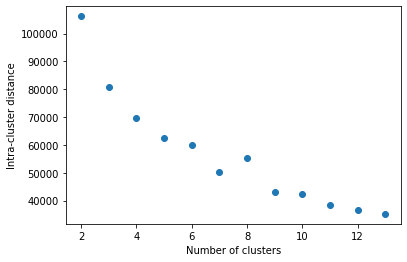

In [187]:
import matplotlib.pyplot as plt
cluster_number = range(2,14)
plt.xlabel('Number of clusters')
plt.ylabel('Intra-cluster distance')
plt.scatter(cluster_number,errors)
plt.show()

It appears that 7 clusters performs well enough

In [18]:
from pyspark.ml.clustering import KMeansModel
    
model_path = '/home/blunt/programming/data_science/kmeans_models/kmeans_model_k_7'
model = KMeansModel.load(model_path)
preds = model.transform(scoring_df)#summary.predictions


In [23]:
preds.toPandas()

A pivot table can now be made to count the wins and losses in each cluster and then calculate the win percentage within each cluster to see if there are any clusters that tend to have more winners.

In [19]:
pivot_table = preds.groupBy('prediction').pivot('result').count()
pivot_table.withColumn('win%',pivot_table.W/(pivot_table.L+pivot_table.W)).\
    show()

+----------+-----+-----+-------------------+
|prediction|    L|    W|               win%|
+----------+-----+-----+-------------------+
|         1|29731|26479| 0.4710727628535848|
|         6|17599|20100| 0.5331706411310645|
|         3| 9953|12531| 0.5573296566447251|
|         5|26707|26131|0.49454937734206444|
|         4|25238|22578| 0.4721850426635436|
|         2|21600|27855| 0.5632393084622384|
|         0|15707|11477|0.42219688051795173|
+----------+-----+-----+-------------------+



There does not appear to be a cluster or groups of clusters that contain players who consistently win.

It is possible to further analyse these clusters by checking if there are particular clusters that contain certain teams, describe the scoring statistics within these clusters, etc.

In [20]:
players = preds.select('name','team',*preds.columns[3:16],'prediction')

In [21]:
p_df = players.groupBy('prediction').avg().orderBy('prediction').toPandas()

22/07/09 23:51:03 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [22]:
p_df

,prediction,avg(pts),avg(fgm),avg(fga),avg(pm3),avg(pa3),avg(ftm),avg(fta),avg(ast),avg(ft%),avg(fg%),avg(3p%),avg(2p%),avg(prediction)
0,0,6.832291,1.756585,7.514751,0.640377,2.781158,2.678745,3.128715,2.257983,0.876686,0.209762,0.151808,0.186901,0.0
1,1,1.241701,0.507419,3.131453,0.150525,1.176855,0.076339,0.242982,0.991550,0.030180,0.081508,0.038623,0.073538,1.0
2,2,20.426469,7.040906,13.667374,2.599414,5.247518,3.745243,4.447154,3.710929,0.861644,0.531890,0.552274,0.527146,2.0
3,3,12.183286,4.687066,6.806173,0.247420,1.136942,2.561733,3.389922,1.694405,0.789833,0.712695,0.067586,0.837062,3.0
4,4,13.081249,4.779593,11.011523,0.276895,2.096892,3.245169,4.242157,2.815041,0.776906,0.434698,0.058552,0.515656,4.0
5,5,6.745713,3.199005,6.240603,0.290605,1.574662,0.057099,0.382357,1.589689,0.013323,0.563573,0.067956,0.699546,5.0
6,6,10.429905,4.093928,8.114671,2.140932,3.831348,0.101117,0.353192,2.125892,0.036011,0.540511,0.643502,0.383267,6.0


In [23]:
top_scorers = preds.select('name','team',*preds.columns[3:16],'prediction').\
    filter(preds['prediction']==2).toPandas()#.show()

In [24]:
top_scorers.value_counts('name').sort_values()

name
Zoran Dragic        1
Earl Watson         1
Elijah Hughes       1
Gigi Datome         1
Gilbert Arenas      1
                 ... 
Damian Lillard    523
LeBron James      563
Kevin Durant      570
Stephen Curry     609
James Harden      669
Length: 994, dtype: int64

In [25]:
top_scorers.value_counts(['name','team'],normalize=True).sort_values().tail(20)

name                   team
Jayson Tatum           BOS     0.004792
Carmelo Anthony        NYK     0.004853
Donovan Mitchell       UTA     0.005015
Kyrie Irving           CLE     0.005156
Giannis Antetokounmpo  MIL     0.005237
Nikola Jokic           DEN     0.005257
Mike Conley            MEM     0.005257
Karl-Anthony Towns     MIN     0.005803
Devin Booker           PHX     0.005844
CJ McCollum            POR     0.006046
Kevin Durant           OKC     0.006147
Kemba Walker           CHA     0.006471
Khris Middleton        MIL     0.006632
Russell Westbrook      OKC     0.007057
Klay Thompson          GSW     0.007138
Kyle Lowry             TOR     0.007482
Bradley Beal           WAS     0.007886
Damian Lillard         POR     0.010575
James Harden           HOU     0.011101
Stephen Curry          GSW     0.012314
dtype: float64

In [ ]:
# ALS MODEL. DO RESEARCH ON IT!

In [29]:
top_scorers.value_counts(['team'],normalize=True).sort_values()

team
DET     0.027742
NOP     0.029441
CHI     0.029623
SAS     0.029987
SAC     0.030048
LAL     0.030048
NYK     0.030957
PHI     0.030978
MEM     0.031160
UTA     0.031261
MIA     0.031463
ORL     0.031483
CHA     0.031807
BKN     0.032009
WAS     0.032413
IND     0.033161
MIN     0.033303
PHX     0.033788
MIL     0.034172
DAL     0.035103
CLE     0.035204
TOR     0.035386
ATL     0.035628
POR     0.036114
OKC     0.036377
LAC     0.036538
DEN     0.037024
HOU     0.038439
BOS     0.038985
GSW     0.040360
dtype: float64

In [1]:
from sqlalchemy import create_engine

def make_engine(user, pswd, db):

    return create_engine("mariadb+mariadbconnector://"\
                        +user+":"\
                        +pswd+"@127.0.0.1:3306/"+db)

In [2]:
query = 'select players.name as name, A.*  from '
query += '(select teams.name as team, box_scores.* from box_scores inner join teams on ' 
query += 'team_id = id) ' 
query += 'A inner join players on player_id = id'

from os import environ

engine = make_engine(environ.get('USER'),environ.get('PSWD'),'nba')

In [3]:
import pandas as pd

# df = pd.read_sql(query,engine)

In [4]:
query = 'select players.name as name, A.*  from '
query += '(select teams.name as team, play_by_plays.* from play_by_plays inner join teams on ' 
query += 'team_id = id) ' 
query += 'A inner join players on player_id = id'


# pbp = spark.read.format('jdbc').option('url','jdbc:mysql://localhost:3306/nba').\
#     option('user',environ.get('USER')).option('password',environ.get('PSWD')).\
#     option('query',query).load()
pbp = pd.read_sql(query,engine, chunksize=500000)

In [5]:
df = next(pbp)

In [6]:
df = pd.concat((df,next(pbp)))

In [7]:
df.drop_duplicates()

,name,team,game_id,action_id,player_id,team_id,period,minute,seconds,x_loc,...,shot_distance,shot_result,field_goal,home_score,away_score,total_points,location,description,action_type,sub_type
0,Marvin Williams,ATL,0021100018,4,101107,1610612737,1,11,38.0,144,...,26,Made,1,0.0,3.0,3,v,Williams 26' 3PT Jump Shot (3 PTS) (Teague 1 AST),Made Shot,Jump Shot
1,Marvin Williams,ATL,0021100018,6,101107,1610612737,1,11,18.0,0,...,0,,0,NaN,NaN,0,v,Williams REBOUND (Off:0 Def:1),Rebound,Unknown
2,Joe Johnson,ATL,0021100018,7,2207,1610612737,1,10,58.0,231,...,0,Missed,1,NaN,NaN,0,v,MISS J. Johnson 3PT Jump Shot,Missed Shot,Jump Shot
3,Josh Smith,ATL,0021100018,8,2746,1610612737,1,10,56.0,0,...,0,,0,NaN,NaN,0,v,Smith REBOUND (Off:1 Def:0),Rebound,Unknown
4,Al Horford,ATL,0021100018,9,201143,1610612737,1,10,42.0,51,...,11,Missed,1,NaN,NaN,0,v,MISS Horford 11' Running Bank Shot,Missed Shot,Running Bank shot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,Kobe Bryant,LAL,0021400279,432,977,1610612747,4,5,25.0,29,...,10,Missed,1,0.0,0.0,0,v,MISS Bryant 10' Turnaround Jump Shot,Missed Shot,Turnaround Jump Shot
499996,Nick Young,LAL,0021400279,435,201156,1610612747,4,5,24.0,0,...,0,,0,0.0,0.0,0,v,SUB: W. Johnson FOR Young,Substitution,
499997,Kobe Bryant,LAL,0021400279,437,977,1610612747,4,4,44.0,-138,...,15,Missed,1,0.0,0.0,0,v,MISS Bryant 15' Jump Shot,Missed Shot,Jump Shot
499998,Ed Davis,LAL,0021400279,438,202334,1610612747,4,4,40.0,0,...,0,,0,0.0,0.0,0,v,Davis REBOUND (Off:2 Def:5),Rebound,Unknown


In [ ]:
pbp.select('description').show()

In [5]:
pbp.iloc[:5,5:]

,team_id,period,minute,seconds,x_loc,y_loc,shot_distance,shot_result,field_goal,home_score,away_score,total_points,location,description,action_type,sub_type
0,1610612737,1,11,38.0,144,220,26,Made,1,0.0,3.0,3,v,Williams 26' 3PT Jump Shot (3 PTS) (Teague 1 AST),Made Shot,Jump Shot
1,1610612737,1,11,18.0,0,0,0,,0,NaN,NaN,0,v,Williams REBOUND (Off:0 Def:1),Rebound,Unknown
2,1610612737,1,10,58.0,231,19,0,Missed,1,NaN,NaN,0,v,MISS J. Johnson 3PT Jump Shot,Missed Shot,Jump Shot
3,1610612737,1,10,56.0,0,0,0,,0,NaN,NaN,0,v,Smith REBOUND (Off:1 Def:0),Rebound,Unknown
4,1610612737,1,10,42.0,51,93,11,Missed,1,NaN,NaN,0,v,MISS Horford 11' Running Bank Shot,Missed Shot,Running Bank shot


In [18]:
pbp.value_counts('sub_type').head(20)

sub_type
Jump Shot               482226
Unknown                 472468
                        381447
Layup Shot              113036
Free Throw 1 of 2       107681
Free Throw 2 of 2       107556
Shooting                101987
Personal                 72637
Bad Pass                 69107
Driving Layup Shot       52710
Lost Ball                32042
Pullup Jump shot         31292
Free Throw 1 of 1        22467
Foul                     19867
Dunk Shot                17856
Hook Shot                15933
Tip Shot                 15928
Running Jump Shot        14630
Turnaround Jump Shot     14601
Loose Ball               14024
dtype: int64

In [8]:
dame = pbp[pbp['name']=='Damian Lillard']
steph = pbp[pbp['name']== 'Stephen Curry']

In [9]:
dame.value_counts('sub_type')

sub_type
Jump Shot                       2477
Unknown                         1136
                                1075
Driving Layup Shot               631
Free Throw 1 of 2                561
                                ... 
Free Throw Clear Path 2 of 2       1
Free Throw Clear Path 1 of 2       1
Double Technical                   1
Double Dribble                     1
Kicked Ball Violation              1
Length: 86, dtype: int64

In [19]:
dame

,name,team,game_id,action_id,player_id,team_id,period,minute,seconds,x_loc,...,shot_distance,shot_result,field_goal,home_score,away_score,total_points,location,description,action_type,sub_type
1608711,Damian Lillard,POR,0021900153,25,203081,1610612757,1,8,24.0,0,...,0,,0,NaN,NaN,0,v,Lillard BLOCK (1 BLK),,
1608719,Damian Lillard,POR,0021900153,36,203081,1610612757,1,7,0.0,0,...,0,,0,NaN,NaN,0,v,Lillard REBOUND (Off:0 Def:1),Rebound,Unknown
1608725,Damian Lillard,POR,0021900153,49,203081,1610612757,1,5,55.0,183,...,18,Made,1,5.0,15.0,20,v,Lillard 18' Jump Shot (2 PTS) (Bazemore 2 AST),Made Shot,Jump Shot
1608726,Damian Lillard,POR,0021900153,53,203081,1610612757,1,5,55.0,0,...,0,,0,5.0,16.0,21,v,Lillard Free Throw 1 of 1 (3 PTS),Free Throw,Free Throw 1 of 1
1608730,Damian Lillard,POR,0021900153,60,203081,1610612757,1,5,28.0,0,...,0,,0,NaN,NaN,0,v,Lillard Step Out of Bounds Turnover (P1.T3),Turnover,Step Out of Bounds Turnover
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688777,Damian Lillard,POR,0021500748,456,203081,1610612757,4,0,40.9,0,...,0,,0,0.0,0.0,0,h,Lillard STEAL (1 STL),,
1688782,Damian Lillard,POR,0021500748,467,203081,1610612757,4,0,29.9,-22,...,2,Missed,1,0.0,0.0,0,h,MISS Lillard 2' Layup,Missed Shot,Layup Shot
1688785,Damian Lillard,POR,0021500748,475,203081,1610612757,4,0,20.1,0,...,0,,0,102.0,108.0,210,h,Lillard Free Throw 1 of 2 (26 PTS),Free Throw,Free Throw 1 of 2
1688787,Damian Lillard,POR,0021500748,478,203081,1610612757,4,0,20.1,0,...,0,,0,103.0,108.0,211,h,Lillard Free Throw 2 of 2 (27 PTS),Free Throw,Free Throw 2 of 2


In [22]:
steph.sort_values(['game_id','action_id'])#.value_counts('sub_type')

,name,team,game_id,action_id,player_id,team_id,period,minute,seconds,x_loc,...,shot_distance,shot_result,field_goal,home_score,away_score,total_points,location,description,action_type,sub_type
564625,Stephen Curry,GSW,0021100005,5,201939,1610612744,1,10,51.0,70,...,19,Made,1,4.0,3.0,7,h,Curry 19' Jump Shot (2 PTS),Made Shot,Jump Shot
564630,Stephen Curry,GSW,0021100005,15,201939,1610612744,1,9,33.0,0,...,0,,0,0.0,0.0,0,h,Curry BLOCK (1 BLK),,
564632,Stephen Curry,GSW,0021100005,17,201939,1610612744,1,9,22.0,-234,...,24,Missed,1,0.0,0.0,0,h,MISS Curry 24' 3PT Jump Shot,Missed Shot,Jump Shot
564639,Stephen Curry,GSW,0021100005,27,201939,1610612744,1,8,6.0,0,...,0,,0,0.0,0.0,0,h,Curry P.FOUL (P1.T1),Foul,Personal
564642,Stephen Curry,GSW,0021100005,31,201939,1610612744,1,7,46.0,0,...,0,,0,0.0,0.0,0,h,Curry REBOUND (Off:1 Def:0),Rebound,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646414,Stephen Curry,GSW,0021500836,441,201939,1610612744,4,3,19.0,1,...,0,Made,1,84.0,93.0,177,v,Curry Running Finger Roll Layup (32 PTS) (Bog...,Made Shot,Running Finger Roll Layup Shot
646417,Stephen Curry,GSW,0021500836,449,201939,1610612744,4,2,36.0,14,...,1,Made,1,84.0,95.0,179,v,Curry 1' Driving Layup (34 PTS),Made Shot,Driving Layup Shot
646425,Stephen Curry,GSW,0021500836,470,201939,1610612744,4,1,4.0,28,...,27,Missed,1,0.0,0.0,0,v,MISS Curry 27' 3PT Pullup Jump Shot,Missed Shot,Pullup Jump shot
646430,Stephen Curry,GSW,0021500836,483,201939,1610612744,4,0,36.1,0,...,0,,0,90.0,101.0,191,v,Curry Free Throw 1 of 2 (35 PTS),Free Throw,Free Throw 1 of 2


In [97]:
shots_only = pbp[pbp['sub_type'].str.contains('Shot',case=False)]#.value_counts('sub_type')

In [98]:
ra_shots = shots_only[(shots_only['sub_type'].str.contains('Dunk'))| 
(shots_only['sub_type'].str.contains('Layup')) | (shots_only['sub_type'].str.contains('Putback'))]

In [99]:
ra_shots.value_counts('sub_type')

sub_type
Layup Shot                        113036
Driving Layup Shot                 52710
Dunk Shot                          17856
Reverse Layup Shot                  9962
Running Layup Shot                  7219
Putback Layup Shot                  6584
Slam Dunk Shot                      6513
Alley Oop Dunk Shot                 6078
Driving Finger Roll Layup Shot      5745
Driving Reverse Layup Shot          4782
Driving Dunk Shot                   4741
Alley Oop Layup shot                3094
Tip Layup Shot                      2866
Putback Dunk Shot                   2833
Finger Roll Layup Shot              2580
Cutting Layup Shot                  2081
Driving Slam Dunk Shot              2023
Running Dunk Shot                   1666
Cutting Dunk Shot                    882
Running Slam Dunk Shot               704
Running Finger Roll Layup Shot       696
Running Reverse Layup Shot           624
Reverse Dunk Shot                    574
Putback Slam Dunk Shot               572
Cutting

In [100]:
jumpshots = shots_only[shots_only['sub_type'].str.contains('Jump Shot',case=False)]

In [101]:
jumpshots.value_counts('sub_type')

sub_type
Jump Shot                             482226
Pullup Jump shot                       31292
Running Jump Shot                      14630
Turnaround Jump Shot                   14601
Floating Jump shot                     13838
Fadeaway Jump Shot                     12612
Step Back Jump shot                    12226
Driving Jump shot                       5551
Driving Floating Jump Shot              1246
Driving Floating Bank Jump Shot          309
Running Pull-Up Jump Shot                202
Turnaround Fadeaway Bank Jump Shot        53
Step Back Bank Jump Shot                  29
dtype: int64

In [16]:
import numpy as np
# np.sqrt(jumpshots['x_loc']**2 + jumpshots['y_loc']**2)

In [30]:
jumpshots[['x_loc','y_loc','shot_distance','field_goal','description']].describe()

,x_loc,y_loc,shot_distance,field_goal
count,525908.000000,525908.000000,525908.000000,525908.0
mean,-1.568706,117.597059,17.336717,1.0
std,138.156495,89.026493,8.615921,0.0
min,-266.000000,-51.000000,0.000000,1.0
25%,-122.000000,34.000000,11.000000,1.0
50%,1.000000,119.000000,19.000000,1.0
75%,116.000000,189.000000,25.000000,1.0
max,300.000000,877.000000,89.000000,1.0


<AxesSubplot:xlabel='x_loc', ylabel='y_loc'>

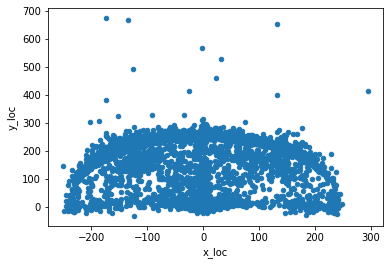

In [31]:
dame[['x_loc','y_loc']].\
    plot(kind = 'scatter',x ='x_loc',y ='y_loc')

<AxesSubplot:xlabel='x_loc', ylabel='y_loc'>

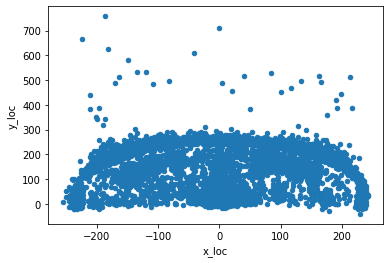

In [32]:
steph[['x_loc','y_loc']].\
    plot(kind = 'scatter',x ='x_loc',y ='y_loc')

In [33]:
import seaborn as sns

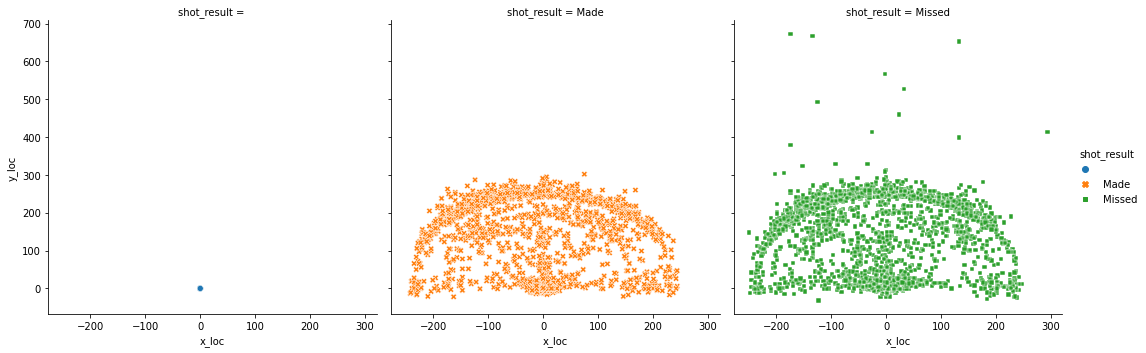

In [36]:
sns.relplot(data = dame, x='x_loc', y ='y_loc',style='shot_result',hue='shot_result',col='shot_result',kind='scatter')

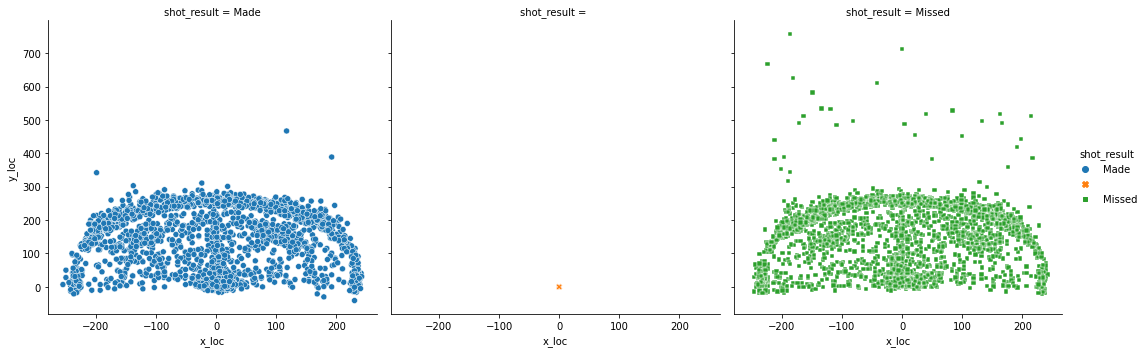

In [35]:
sns.relplot(data = steph, x='x_loc', y ='y_loc',style='shot_result',hue='shot_result',col='shot_result',kind='scatter')

In [37]:
dame.value_counts('shot_result')

shot_result
          5145
Missed    2820
Made      2117
dtype: int64